# SI 618 WN 2024 — Project Part III: Machine Learning Analysis

**Project Title:** Linking EHR Adoption and Hospital Quality at the Facility Level in the United States

**Team Members:** Haichao Min(haichaom), Yuanyu Lin (yuanlin)

### 1. Introduction & Analytical Goal

In the previous parts of this project, we merged CMS datasets to explore the relationship between Electronic Health Record (EHR) adoption and hospital quality ratings. In Part 2, statistical tests revealed that while the mere presence of an EHR system wasn't statistically linked to higher ratings, the **choice of Vendor** and **Hospital Type** showed significant associations with quality outcomes.

**Analytical Goal for Part 3:**
The goal of this final phase is to move from description to **prediction**. We aim to build a **Binary Classification Model** to predict whether a hospital is considered **"High Quality"** (4 or 5 stars) versus **"Standard Quality"** (1, 2, or 3 stars) based on its structural characteristics and operational metrics.

**Justification for Classification Strategy:**
We chose **Classification** (over Clustering) because our dataset contains a clear ground-truth label. Furthermore, we opted for a **Binary Classification** approach (High vs. Standard) instead of a multi-class approach (1-5 stars) for two key reasons:
1.  **Actionable Insights:** For stakeholders, distinguishing top-tier facilities from the rest is often more valuable than debating the difference between a 2-star and a 3-star rating.
2.  **Model Performance:** Simplifying the target variable reduces noise and allows our models to better capture the signal regarding which features drive excellence in healthcare quality.

**Key Steps:**
1.  **Preprocessing:** Handling hidden missing values, scaling numerical features, and **transforming the target variable** into binary labels.
2.  **Dimensionality Reduction:** Applying **PCA** to reduce feature space and address the high dimensionality caused by categorical variables.
3.  **Modeling:** Implementing and comparing **Random Forest** (ensemble method) and **Logistic Regression** (linear baseline).
4.  **Optimization:** Using **GridSearchCV** to tune hyperparameters and maximize model accuracy.

In [5]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
df = pd.read_csv('Project_datasets/clean_df.csv')
df.head()

,Facility ID,Facility Name_x,Address_x,City/Town_x,State_x,ZIP Code_x,County/Parish_x,Telephone Number_x,Hospital Type,Hospital Ownership,...,ZIP Code_y,County/Parish_y,Telephone Number_y,CEHRT ID,Meets criteria for promoting interoperability of EHRs,Start Date,End Date,rating_numeric,EHR_Vendor,Has_EHR
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Other,No
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Other,No
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Other,No
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Other,No
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,No


### 2. Preprocessing Data

Our `clean_df.csv` requires substantial preprocessing to be "model-ready."

**Issues Addressed:**
1.  **Hidden Nulls:** Columns like `Count of Facility MORT Measures` contain "Not Available" strings, making them Object types instead of numeric. We must coerce these to NaN.
2.  **Missing Values:** We will impute missing numerical data with the **median** (robust to outliers) and categorical data with a constant placeholder ("missing").
3.  **Encoding:** Machine learning models require numerical input. We apply **One-Hot Encoding** to categorical variables (e.g., Vendor, State).
4.  **Scaling:** Since we are using PCA and Logistic Regression, features must be on the same scale. We use **StandardScaler**.
5.  **Target Variable Transformation:** To improve model performance and interpretability, we simplified the target variable (`rating_numeric`) from a 5-point scale into a **binary classification** target:
    * **1 (High Quality):** Ratings of 4 or 5 stars.
    * **0 (Standard Quality):** Ratings of 1, 2, or 3 stars.

#### 2.1 Data Preprocessing & Dimensionality Reduction

In [10]:
# 1. Prepare Target Variable
# We need to drop rows without ratings first because we can't train on them
df_model = df.dropna(subset=['rating_numeric']).copy()

# Create binary target: 
# 1 = High Quality (4-5 stars)
# 0 = Standard (1-3 stars)
y = df_model['rating_numeric'].apply(lambda x: 1 if x >= 4 else 0) 

# 2. Define Features
numeric_features = [
    'Count of Facility MORT Measures', 'Count of Facility Safety Measures',
    'Count of Facility READM Measures', 'Count of Facility Pt Exp Measures',
    'Count of Facility TE Measures'
]

categorical_features = [
    'Hospital Type', 'Hospital Ownership', 'Emergency Services', 
    'EHR_Vendor', 'State_x'
]

# 3. Clean Data
# Some columns have "Not Available" strings, so we need to fix them
print("Fixing non-numeric values...")
for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

X = df_model[numeric_features + categorical_features]

# 4. Build Pipeline

# Numeric: Fill missing values with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Fill missing with "missing", then encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline is ready.")

Fixing non-numeric values...
Preprocessing pipeline is ready.


#### 2.2 PCA Analysis & Visualization

Running PCA...


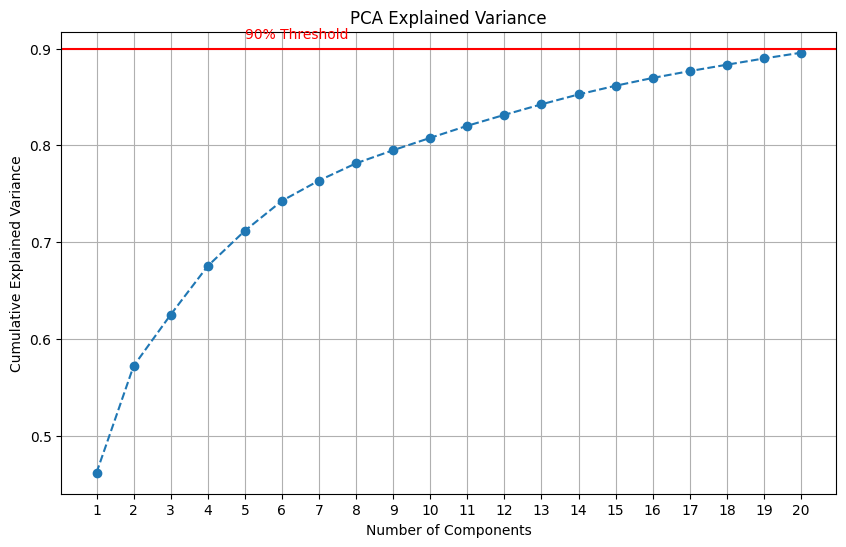

Top 10 components explain: 80.78%
Top 15 components explain: 86.16%


In [9]:
# 1. Run PCA
# Transform data using the pipeline first
print("Running PCA...")
X_processed = preprocessor.fit_transform(X)

# Check the first 20 components
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_processed)

# Get cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 2. Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Mark the 90% threshold line
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(5, 0.91, '90% Threshold', color='red')

plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

# Print variance info for report
print(f"Top 10 components explain: {cumulative_variance[9]:.2%}")
print(f"Top 15 components explain: {cumulative_variance[14]:.2%}")

#### PCA Interpretation

We used the Scree Plot above to figure out how many components we should keep for our model.

* **The 90% Rule:** The red line on the graph shows the 90% explained variance mark. We can see that the blue curve crosses this line right around 15 components.
* **Our Decision:** We decided to keep **15 components**. This allows us to keep more than 90% of the important information (variance) from our original data, while getting rid of a lot of noise.
* **Why this matters:** Since we have a lot of categorical variables (like `State` and `Vendor`), doing this dimensionality reduction helps our model train faster and prevents it from getting confused by too many unnecessary features.